<div style="color:pink">
hier möchte ich einmal versuchen, die Pixel, die von Bots gesetzt wurden, nachzuzeichnen
</div>

In [1]:
#alle Schritte, die nötig waren, um die Bots einzustufen
from src.data.dataset_functions import get_dataframe
import pyspark.sql.functions as F

dataFrame = get_dataframe(True)

timeFrame = dataFrame.alias('df1').join(dataFrame.alias('df2'),F.col('df1.user_id') == F.col('df2.user_id'),'inner')
timeFrame = timeFrame.where('df2.t > df1.t')
timeFrame = timeFrame.orderBy(['df1.user_id', 'df1.t'])
timeFrame = timeFrame.select(F.col('df1.user_id'),F.col('df1.t').alias('t1'),F.col('df2.t').alias('t2'),(F.col('df2.t') - F.col('df1.t')).alias('diff'))
timeReduced = timeFrame.dropDuplicates(['user_id', 't1'])

bot = timeReduced.alias('tdr1').join(timeReduced.alias('tdr2'),F.col('tdr1.user_id') == F.col('tdr2.user_id'),'inner').join(timeReduced.alias('tdr3'),F.col('tdr1.user_id') == F.col('tdr3.user_id'), 'inner')
bot = bot.where('tdr1.diff == tdr2.diff').where('tdr1.t2 == tdr2.t1').where('tdr3.diff == tdr1.diff').where('tdr2.t2 == tdr3.t1')
bot = bot.select('tdr1.user_id','tdr1.diff')
bot = bot.dropDuplicates(['user_id'])

providing ../data/raw/2022_place_canvas_history-000000000050.csv ...
../data/raw/2022_place_canvas_history-000000000050.csv is already in data/raw
providing ../data/raw/2022_place_canvas_history-000000000051.csv ...
not found. need to download ../data/raw/2022_place_canvas_history-000000000051.csv.gzip ...
downloading from https://placedata.reddit.com/data/canvas-history/2022_place_canvas_history-000000000051.csv.gzip to ../data/raw/2022_place_canvas_history-000000000051.csv.gzip
unpacking ../data/raw/2022_place_canvas_history-000000000051.csv.gzip into ../data/raw/2022_place_canvas_history-000000000051.csv
deleting ../data/raw/2022_place_canvas_history-000000000051.csv.gzip
providing ../data/raw/2022_place_canvas_history-000000000052.csv ...
not found. need to download ../data/raw/2022_place_canvas_history-000000000052.csv.gzip ...
downloading from https://placedata.reddit.com/data/canvas-history/2022_place_canvas_history-000000000052.csv.gzip to ../data/raw/2022_place_canvas_history-

Ivy Default Cache set to: /home/vscode/.ivy2/cache
The jars for the packages stored in: /home/vscode/.ivy2/jars
graphframes#graphframes added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-28d8ec76-2e39-40be-91ab-a1e688c0ad3b;1.0
	confs: [default]
	found graphframes#graphframes;0.8.2-spark3.2-s_2.12 in spark-packages
	found org.slf4j#slf4j-api;1.7.16 in central
:: resolution report :: resolve 89ms :: artifacts dl 3ms
	:: modules in use:
	graphframes#graphframes;0.8.2-spark3.2-s_2.12 from spark-packages in [default]
	org.slf4j#slf4j-api;1.7.16 from central in [default]
	---------------------------------------------------------------------
	|                  |            modules            ||   artifacts   |
	|       conf       | number| search|dwnlded|evicted|| number|dwnlded|
	---------------------------------------------------------------------
	|      default     |   2   |   0   |   0   |   0   ||   2   |   0   |
	----------------------------------

22/06/30 09:08:14 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


22/06/30 09:08:15 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
22/06/30 09:08:15 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.


In [2]:
botsTotal = dataFrame.alias('df').join(bot.alias('bd'),F.col('df.user_id') == F.col('bd.user_id'), 'inner')
botsTotal = botsTotal.select(F.col('df.user_id'),F.col('df.x'),F.col('df.y'),F.col('df.t'),F.col('pixel_color'))
botsTotal = botsTotal.orderBy(['user_id', 't'])
botsTotal = botsTotal.dropDuplicates(['user_id', 't']) #jeder Nutzer kann zu jeder Zeit nur einen Pixel gesetzt haben  
botsTotal = botsTotal.drop('t')

<div style="color:pink">
<s>-aktuell verzweifle ich noch daran, die Werte aus dem dataframe iterativ fürs Zeichnen auf mein Canvas zu benutzen <br>
-aus mir unbekannten Gründen nimmt python nämlich nicht die tatsächlichen Werte aus den Spalten, sondern lediglich die Namen der Spalten selbst<br>
-weiterhin muss ich noch irgendwie hinbekommen, dass die hex-codes der farben in die richtigen rgb-werte umgewandelt werden <br> </s>
<br>
Geschafft! :))))
</div>

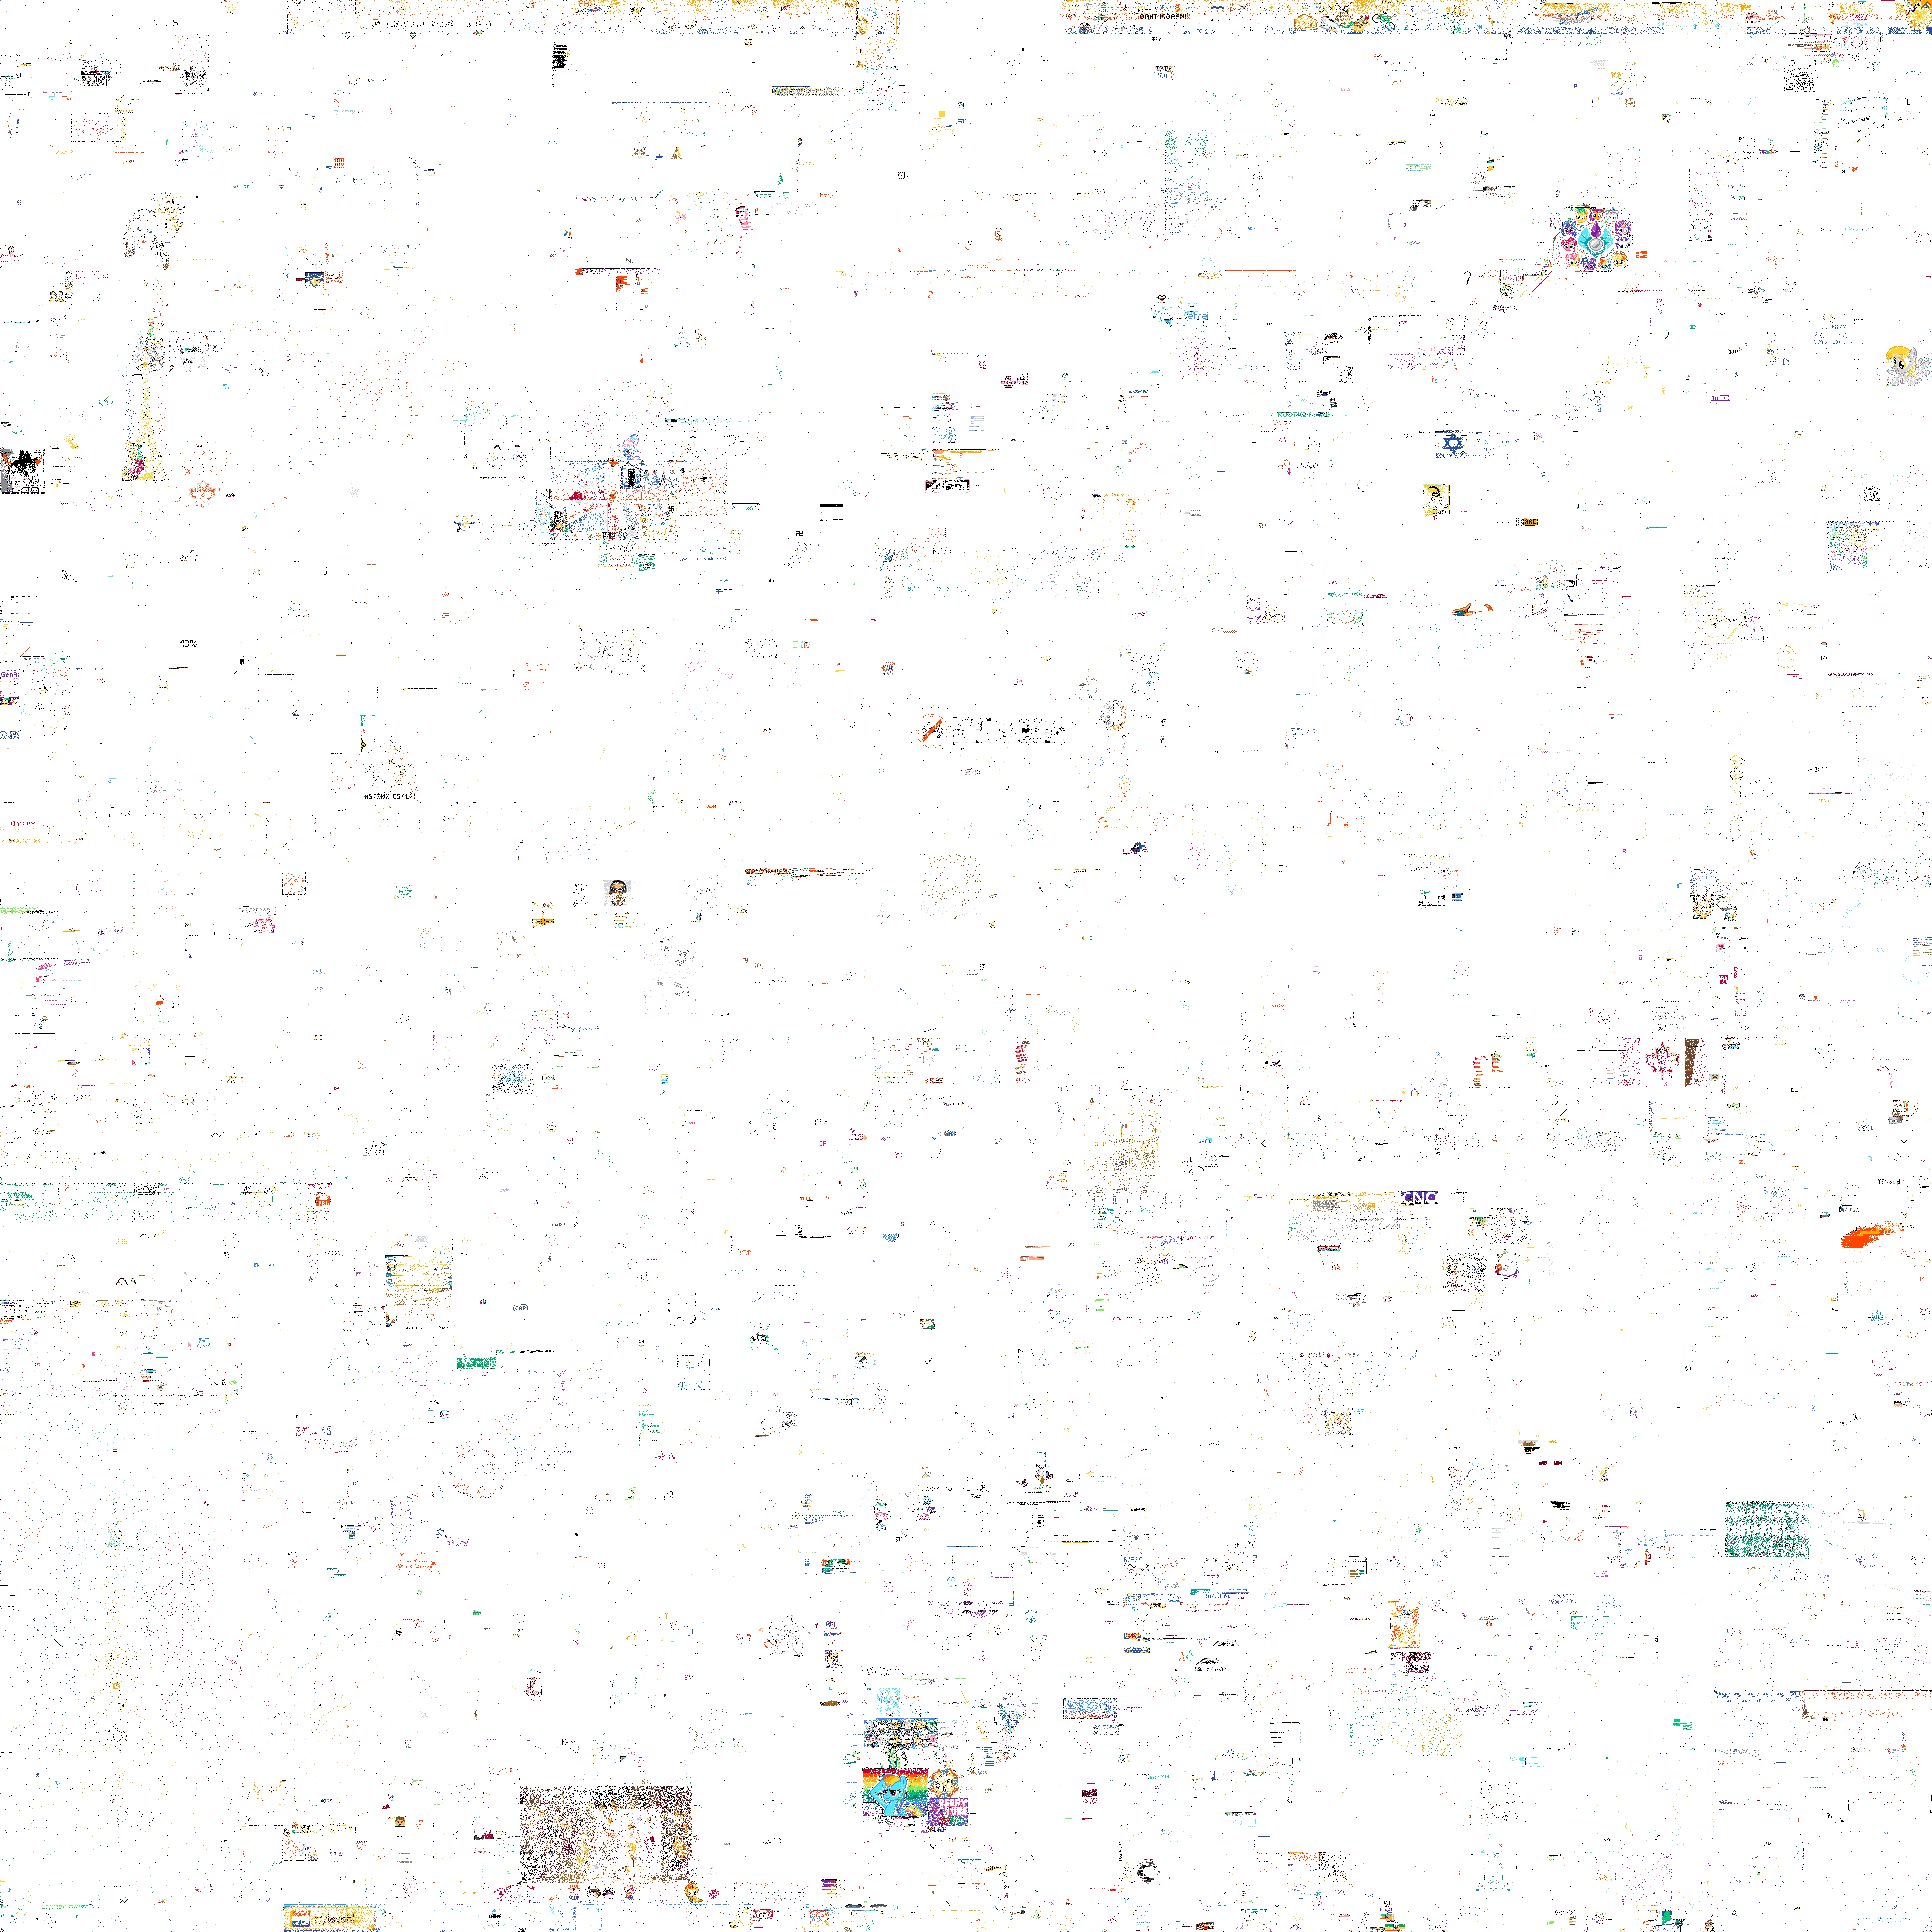

In [4]:
from PIL import Image
from src.visualization.visuialization_functions import hex_to_rgb
  
#ich konvertiere den Datensatz, damit mir das Iterieren etwas leichter fällt
pandasDF = botsTotal.toPandas()
canvas = Image.new("RGB", (2000,2000), "WHITE")

#Schritt für Schritt wird wirklich jeder einzelne Pixel geändert
for index, row in pandasDF.iterrows():
    canvas.putpixel((row['x'],row['y']), hex_to_rgb(row['pixel_color']))

canvas.show()
canvas.save('../reports/figures/bots-canvas.jpg')  